# IS 4487 Lab 11

## Learning Objective

Use Linear Regression to predict the AQI in Utah.

## Outline

- Pull the latest "Daily AQI by County" file from this link: https://aqs.epa.gov/aqsweb/airdata/download_files.html#AQI

- Your target variable will be *AQI", which is the value of the air quality index

- We will focus the analysis on only the air quality in the state of Utah.  

- Note that there is a several-month lag in preparing data; you should check to see if your file has a full year of data from January to December.  If not, use the previous year.    

- The AQI is divided into six categories:

*Air Quality Index*

|(AQI) Values	|Levels of Health Concern	        |
|---------------|--------|
|0-50	        |Good	 |
|51-100	        |Moderate	 |
|101-150	    |Unhealthy for Sensitive Groups	|
|151 to 200	    |Unhealthy	 |
|201 to 300	    |Very Unhealthy	 |
|301 to 500	    |Hazardous	 |

<a href="https://colab.research.google.com/github/Stan-Pugsley/is_4487_base/blob/main/Labs/Scripts/lab_11_air_quality_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Load Libraries

➡️ Assignment Tasks
- Load any necessary libraries

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

## Import Data into Dataframe

➡️ Assignment Tasks
- Pull the latest full year of data using the "Daily AQI by County" files from this link: https://aqs.epa.gov/aqsweb/airdata/download_files.html#AQI
- Make sure to UNZIP the file
- Import data from the air quality dataset into a dataframe
- Describe or profile the dataframe

In [50]:
# Load the dataset
data_path = "https://aqs.epa.gov/aqsweb/airdata/daily_aqi_by_county_2024.zip"
df = pd.read_csv(data_path)

# Preview the data
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206919 entries, 0 to 206918
Data columns (total 10 columns):
 #   Column                     Non-Null Count   Dtype 
---  ------                     --------------   ----- 
 0   State Name                 206919 non-null  object
 1   county Name                206919 non-null  object
 2   State Code                 206919 non-null  int64 
 3   County Code                206919 non-null  int64 
 4   Date                       206919 non-null  object
 5   AQI                        206919 non-null  int64 
 6   Category                   206919 non-null  object
 7   Defining Parameter         206919 non-null  object
 8   Defining Site              206919 non-null  object
 9   Number of Sites Reporting  206919 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 15.8+ MB


## Prepare Data

➡️ Assignment Tasks
- Filter the data to use Utah data only
- Create one dummy variable (true/false) for each of the Defining Parameter values    
- Create variables for month of year, year, and season
- Perform any other data cleanup needed (remove outliers, nulls, etc.)
- After filtering for Utah, remove the geographical variables that remain (county, state) since those non-numeric values can't be used.  Remove any other non-numeric variables.
- Select the data you would like to use in the model.  If you aggregate data, you will have to decide whether to use the min, max or mean value for AQI
- Split the data 80/20 for training and testing

In [51]:
#filter for Utah data only
df_utah = df[df["State Name"] == "Utah"].copy()

In [52]:
#create columns
df["Date"] = pd.to_datetime(df["Date"])
df_utah["month"] = df["Date"].dt.month
df_utah["year"] = df["Date"].dt.year

def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

df_utah["season"] = df_utah["month"].apply(get_season)
df_utah = pd.get_dummies(df_utah, columns=["season"], drop_first=True)

In [53]:
#data cleanup
columns_to_drop = ['State Name', 'county Name', 'State Code', 'County Code', 'Date']
df_utah = df_utah.drop(columns=columns_to_drop, errors='ignore')


In [54]:
#select final columns for use
df_utah = pd.get_dummies(df_utah, columns=["Defining Parameter"], drop_first=True)
df_utah = df_utah.dropna()
df_model = df_utah.copy()

# Drop string/object columns not usable in regression
df_model = df_model.drop(columns=["Category", "Defining Site"])

In [56]:
X = df_model.drop(columns=["AQI"])
y = df_model["AQI"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



## Create Model

➡️ Assignment Tasks
- Create a simple linear regression to predict AQI based on as many variables as you can use or derive.  (for example, sklearn LinearRegression)
- Evaluate the model by displaying the R squared value  
- Visualize the correlation between the target variable and at least one of the independent variables

In [57]:
#create regression or classification model
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [58]:
#print the R squared value
# Predict on the test set
y_pred = model.predict(X_test)

# Calculate R-squared
r2 = r2_score(y_test, y_pred)

print(f"R² Score: {r2:.4f}")

R² Score: 0.2414


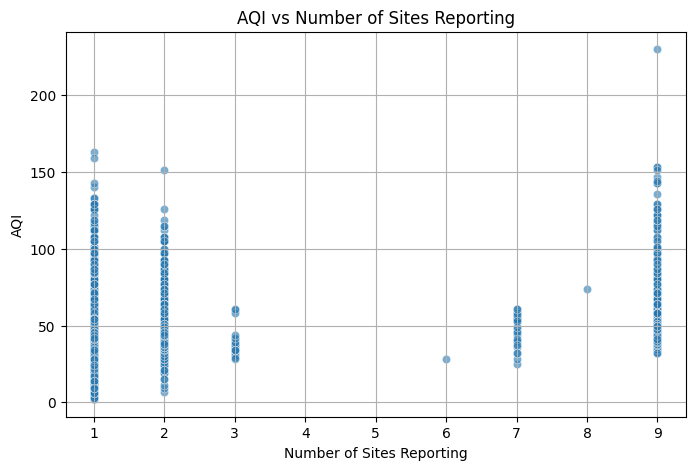

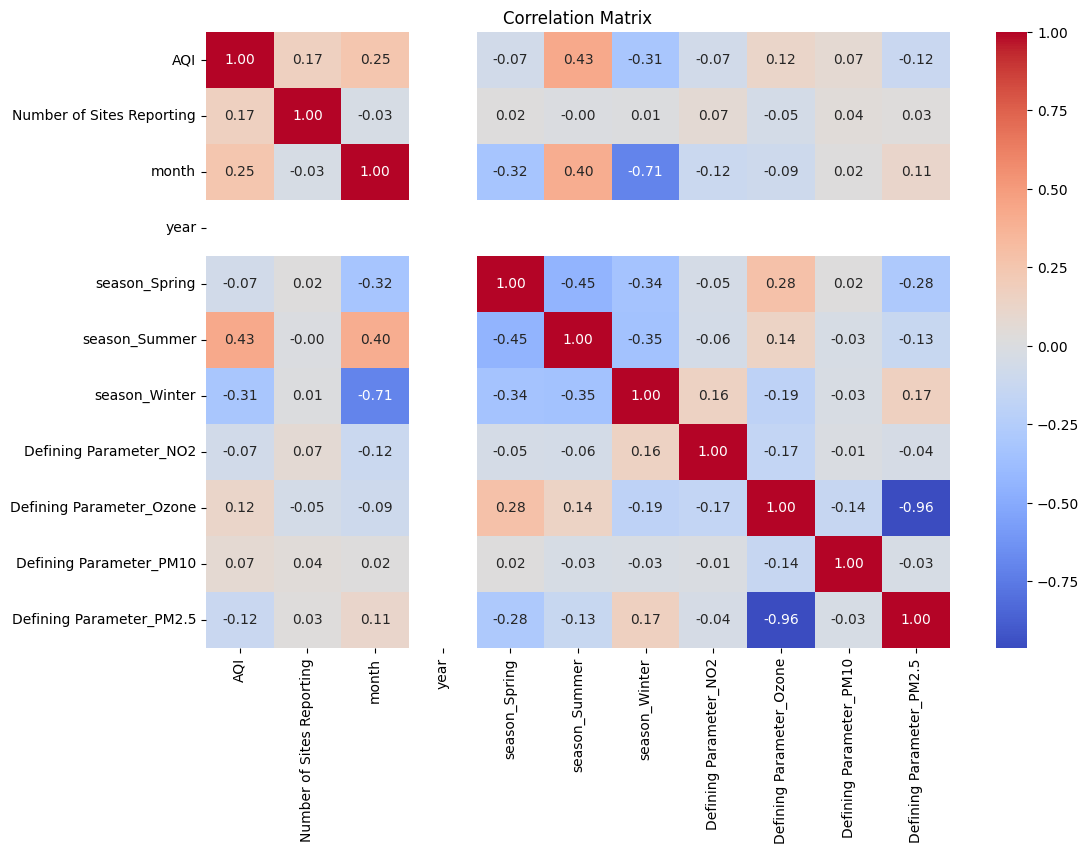

In [60]:
#visual
plt.figure(figsize=(8, 5))
sns.scatterplot(x=df_model["Number of Sites Reporting"], y=df_model["AQI"], alpha=0.6)
plt.title("AQI vs Number of Sites Reporting")
plt.xlabel("Number of Sites Reporting")
plt.ylabel("AQI")
plt.grid(True)
plt.show()

#HeatMap
plt.figure(figsize=(12, 8))
sns.heatmap(df_model.corr(numeric_only=True), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

## Make a prediction

➡️ Assignment Tasks
- What would you predict the average AQI to be in January of the upcoming year?  

In [61]:
#predicted AQI
# Filter to January only
df_january = df_model[df_model["month"] == 1]

# Get average input values for January (excluding AQI)
january_features = df_january.drop(columns=["AQI"]).mean().to_frame().T

# Predict AQI
predicted_aqi = model.predict(january_features)[0]
print(f"Predicted average AQI for next January: {predicted_aqi:.2f}")

Predicted average AQI for next January: 38.11


## OPTIONAL: Compare Air Quality

➡️ Assignment Tasks
- Download the data from several previous years using this website: https://aqs.epa.gov/aqsweb/airdata/download_files.html#AQI
- Append the new data to the previous dataframe
- Use the year as a variable in your regression.  Is year a significant factor in predicting AQI?

In [ ]:
#import, append and create new model

In [66]:

from google.colab import drive
drive.mount('/content/drive')

!cp "/content/lab_11_air_quality_regression-2.ipynb" ./

# create html from ipynb
!jupyter nbconvert --to html "/content/lab_11_air_quality_regression-2.ipynb"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
cp: '/content/lab_11_air_quality_regression-2.ipynb' and './lab_11_air_quality_regression-2.ipynb' are the same file
[NbConvertApp] Converting notebook /content/lab_11_air_quality_regression-2.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 2 image(s).
[NbConvertApp] Writing 527609 bytes to /content/lab_11_air_quality_regression-2.html
